169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - accuracy: 0.0438 - loss: 5.0948 - val_accuracy: 0.1343 - val_loss: 3.7263 - learning_rate: 0.0100
Epoch 2/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - accuracy: 0.1256 - loss: 3.7921 - val_accuracy: 0.1935 - val_loss: 3.3339 - learning_rate: 0.0100
Epoch 3/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.1846 - loss: 3.3822 - val_accuracy: 0.2523 - val_loss: 3.0009 - learning_rate: 0.0100
Epoch 4/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.2295 - loss: 3.1138 - val_accuracy: 0.3238 - val_loss: 2.6581 - learning_rate: 0.0100
Epoch 5/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.2696 - loss: 2.9089 - val_accuracy: 0.3247 - val_loss: 2.6245 - learning_rate: 0.0100
Epoch 6/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.3010 - loss: 2.7515 - val_accuracy: 0.3730 - val_loss: 2.3961 - learning_rate: 0.0100
Epoch 7/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0

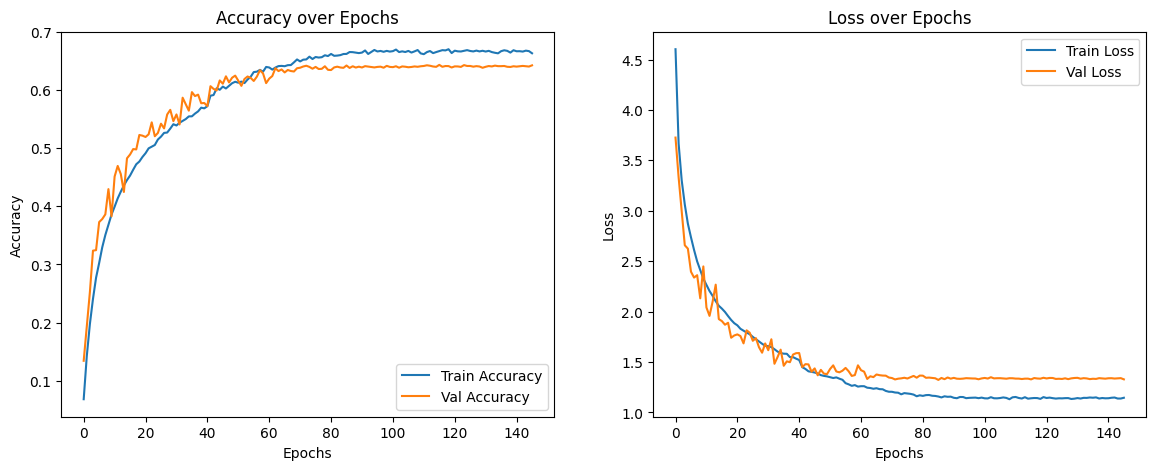

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


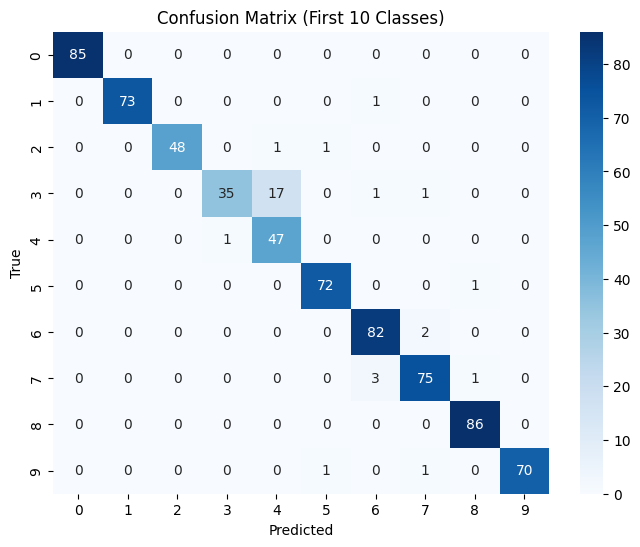


Best Accuracy and Loss:
   Best Validation Accuracy  Best Validation Loss
0                    0.6435              1.322891

Final Test Accuracy: 0.6451


In [1]:
#Final interation of the code
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

# For reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Load and preprocess CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

# 80-20 split from training data
x_train_80, x_val_20, y_train_80, y_val_20 = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

# Mixed precision policy
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Model architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(100, activation='softmax', dtype='float32')
])

# Compile model
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train_80)

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    datagen.flow(x_train_80, y_train_80, batch_size=32),
    steps_per_epoch=len(x_train_80) // 32,
    epochs=200,
    validation_data=(x_val_20, y_val_20),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot accuracy and loss
history_dict = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix (for first 10 classes for clarity)
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(10))
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (First 10 Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Best accuracy and loss
best_acc = max(history_dict['val_accuracy'])
best_loss = min(history_dict['val_loss'])
results_df = pd.DataFrame({
    'Best Validation Accuracy': [best_acc],
    'Best Validation Loss': [best_loss]
})
print("\nBest Accuracy and Loss:")
print(results_df)

# Model architecture visualization
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='model_plot.png')

# Final test evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
